# Deep Reinforcement Learning Laboratory

In this laboratory session we will work on getting more advanced versions of Deep Reinforcement Learning algorithms up and running. Deep Reinforcement Learning is **hard**, and getting agents to stably train can be frustrating and requires quite a bit of subtlety in analysis of intermediate results. We will start by refactoring (a bit) my implementation of `REINFORCE` on the [Cartpole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). 

## Exercise 1: Improving my `REINFORCE` Implementation (warm up)

In this exercise we will refactor a bit and improve some aspects of my `REINFORCE` implementation. 

**First Things First**: Spend some time playing with the environment to make sure you understand how it works.

In [1]:
# Import necessary libraries
# Ensure that the CUBLAS workspace configuration is set to avoid memory issues
# This is particularly useful for environments with limited GPU memory.
# The configuration ':4096:8' is a common setting 
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

In [2]:
# Set the random seed for reproducibility
# This ensures that the results can be replicated by initializing the random number generators
# to a fixed state. It is crucial for debugging and comparing results across different runs.
# The seed value can be any integer, but using a fixed value like 42 is common

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [3]:
# Create the CartPole environment
# This environment is a classic control problem where the goal is to balance a pole on a cart
# The environment provides a continuous state space and discrete action space.
# The 'CartPole-v1' version is a standard benchmark in reinforcement learning.

env = gym.make('CartPole-v1')

env.reset()
print(type(env))
print(type(env.observation_space))
#[cart_position, cart_velocity, pole_angle, pole_angular_velocity]
#low bound [-4.8, -inf, -0.418, -inf]
#high bound [4.8, inf, 0.418, inf]
print(env.observation_space.shape)
print(env.observation_space.low) 
print(env.observation_space.high)

<class 'gymnasium.wrappers.common.TimeLimit'>
<class 'gymnasium.spaces.box.Box'>
(4,)
[-4.8               -inf -0.41887903        -inf]
[4.8               inf 0.41887903        inf]


**Next Things Next**: Now get your `REINFORCE` implementation working on the environment. You can import my (probably buggy and definitely inefficient) implementation here. Or even better, refactor an implementation into a separate package from which you can `import` the stuff you need here. 

In [4]:
# Define directories for data, checkpoints, and logs

data_dir = './data'
checkpoints_dir = './checkpoints'
log_dir = './logs'
# Hyperparameters for the training process
# These parameters control the learning rate, number of episodes, and other aspects of the training process
# Adjusting these parameters can significantly affect the performance and convergence of the learning algorithm.
n_episodes = 250 #1000
lr = 1e-2
lr_s_factor = 0.5
eene = 10
ee = 10
hidden_w = 128
n_hidden_layers = 1
patience = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#TensorBoard setup

%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 192118), started 0:00:03 ago. (Use '!kill 192118' to kill it.)

## 🧹 `clear` Function

This utility function ensures a clean directory by:

1. Checking if the directory exists and is indeed a folder.
2. If so, it deletes the entire directory using `shutil.rmtree()`.
3. Then it recreates the directory using `os.makedirs(..., exist_ok=True)` — safe even if the directory already exists.

It is used to ensure a clean and repeatable environment during experiments, preventing old files (e.g. old saved weights or TensorBoard logs) from interfering with new ones.
Great in automated training pipelines (e.g. in batch scripts or multiple experiments).

In [7]:
# Clear directories for data, checkpoints, and logs
# This function ensures that the specified directories are empty before starting the training process.
# It removes any existing files or directories and creates new ones to ensure a clean state.
# This is useful for avoiding conflicts with previous runs and ensuring that the training starts fresh.



import shutil
import os

def clear(_dir):
    if os.path.exists(_dir):
        if os.path.isdir(_dir):
            shutil.rmtree(_dir)
        os.makedirs(_dir, exist_ok = True)

# Uncomment the following lines to clear the directories
# Note: Be cautious when using this function as it will delete all contents in the specified directories

#clear(data_dir)
#clear(checkpoints_dir)
#clear(log_dir)

In [8]:
# Import custom modules for training pipelines and neural network architectures

from RLTrainingPipeline import RLTrainingPipeline
from QLTrainingPipeline import QLTrainingPipeline
from MLP import MLP

## 🧠 Policy Network for CartPole (MLP-based)

---

### 🎯 What Are We Doing?

We define a **policy network** to solve the classic `CartPole-v1` environment using **reinforcement learning**.  
The policy is a simple but effective **Multi-Layer Perceptron (MLP)** that learns to map **observations** (state vectors) to **action logits**.

---

### 🤖 Why an MLP?

- CartPole has a **continuous** state space and a **discrete** action space.
- An MLP handles low-dimensional, structured data well.
- It provides a flexible and lightweight approximation of the **policy function**.

---

### 🏗️ Architecture Details

- **Input layer:** Matches the state size → 4 values  
  *(cart position, cart velocity, pole angle, pole angular velocity)*  
- **Hidden layers:** Controlled by `n_hidden_layers` and `hidden_w` (number of neurons per layer).
- **Output layer:** One neuron per possible action (2: move left or right)

Example (if `n_hidden_layers = 2` and `hidden_w = 64`):

- **Activation functions:** ReLU for all hidden layers 💡
- **Bias:** Disabled

---

### 🧮 Output

- The model outputs **logits**, not probabilities.
- This allows us to use `torch.distributions.Categorical(logits=...)` for action sampling.
- We avoid `Softmax` in the final layer because:
  - It’s redundant for sampling.
  - It may introduce numerical instability.
  - The `Categorical` distribution handles the conversion internally. 🔥

---

### ⚙️ Optimizer

- **Adam** optimizer is used 🧪
- Learning rate `lr` is a key hyperparameter (typically in range `[1e-3, 1e-4]`)

---

### ⏳ Learning Rate Scheduling (Optional)

- A scheduler like `ReduceLROnPlateau` can be used if needed, but:
  - In RL, reward signals evolve slowly and are noisy.
  - Schedulers are less common or are handled manually.
  - For simplicity, it's commented out in this setup.


In [ ]:
# Define the policy network using a MLP (Multi-Layer Perceptron)

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    #act_funcs = [nn.ReLU] * (n_hidden_layers) + [nn.Softmax], 
    #act_funcs_params = [dict() for _ in range(n_hidden_layers)] + [dict(dim = -1)],
    use_bias = [False, False] 
)

print(policy.blocks)

optimizer = optim.Adam(policy.parameters(), lr = lr)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene) #the metric we are monitoring does not change every step as lr_scheduling

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=False)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=False)
  )
)


**Last Things Last**: My implementation does a **super crappy** job of evaluating the agent performance during training. The running average is not a very good metric. Modify my implementation so that every $N$ iterations (make $N$ an argument to the training function) the agent is run for $M$ episodes in the environment. Collect and return: (1) The average **total** reward received over the $M$ iterations; and (2) the average episode length. Analyze the performance of your agents with these new metrics.

## Dummy Run
We now **test our policy network** inside a training pipeline using the **REINFORCE algorithm** to ensure it:

- Receives observations correctly 
- Outputs valid actions   
- Trains and evaluates without errors   
- Produces learning curves 

---

### 🧪 Setup

We initialize the environment and create the `RLTrainingPipeline`, which handles:

- **Training episodes**
- **Evaluation tracking**
- **Logging and plotting** of the learning process 

---

### ⚙️ Key Parameters

- `env`: the `CartPole-v1` environment   
- `n_episodes`: total episodes to train  
- `eval_every_n_episodes` (→ `eene`): how often to evaluate  
- `eval_episodes` (→ `ee`): number of episodes used to compute evaluation metrics  
- `device`: CPU or GPU (depending on setup)

---

### 📊 Output

Calling `pipeline.plot()` will show how the **average return** evolves over time.  
This gives us a sense of whether the agent is learning to balance the pole .

If the curve trends upward, congratulations — your policy is learning!   
If it’s flat or noisy, time to tune the hyperparameters or network. 

---

### ✅ Sanity Check

This dummy test is essential before scaling to longer training or more complex setups.  
It verifies:

- The forward pass through the MLP   
- Action sampling via logits   
- Basic reward-based training dynamics 



  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [01:04<00:00,  3.89it/s]

training time: 64.33s


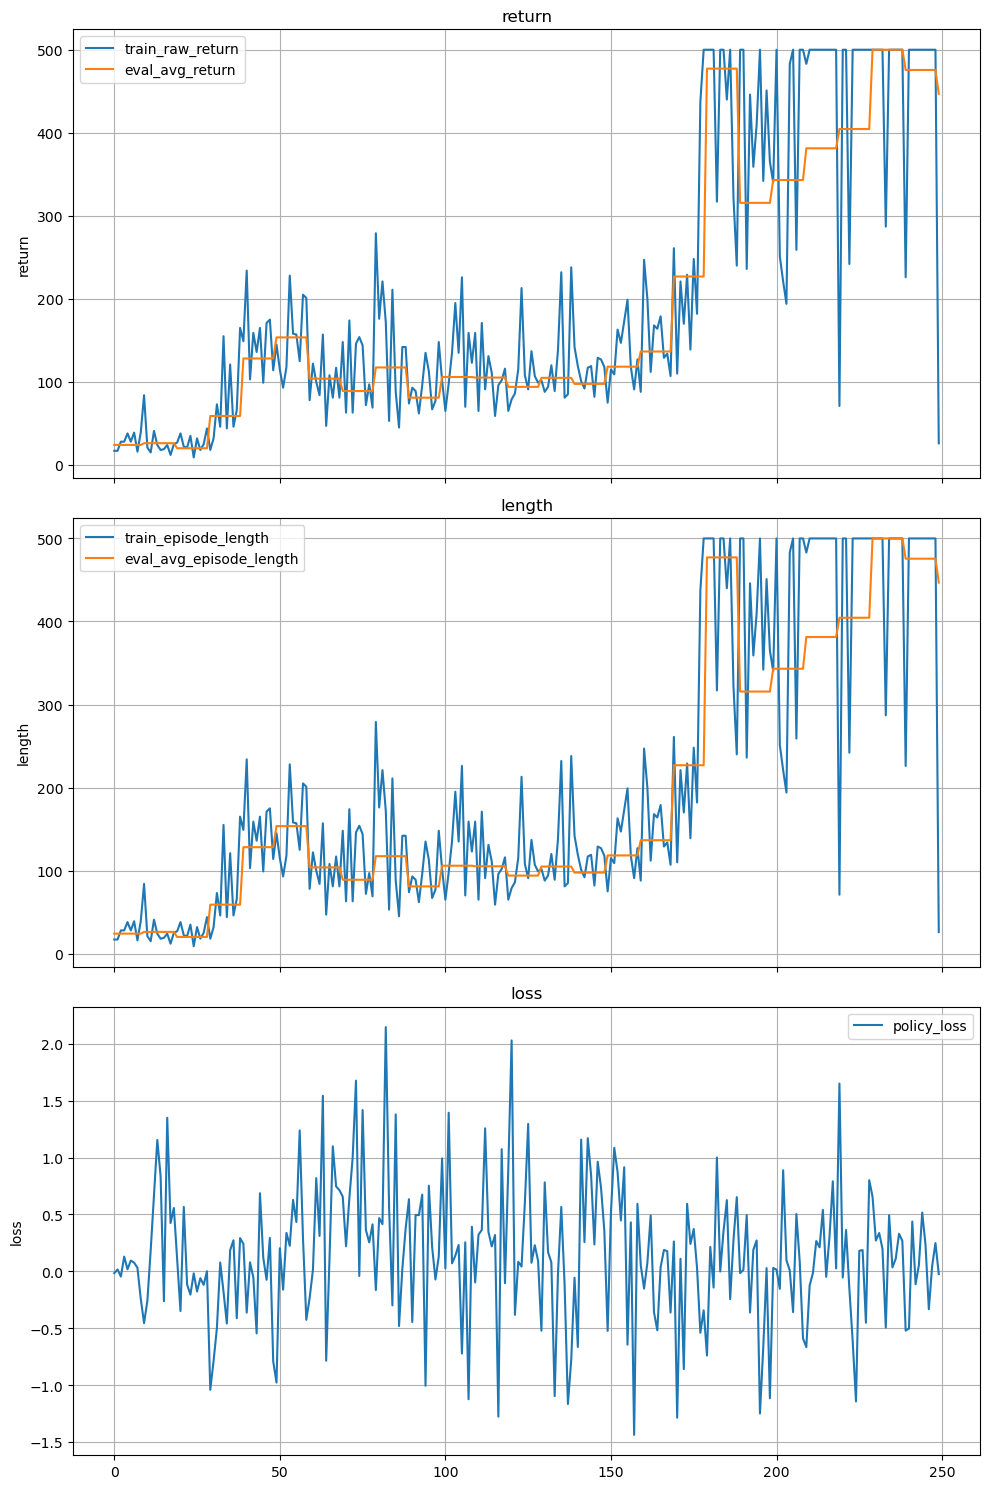

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [10]:
#Test the policy network with a dummy input to ensure it works correctly

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    #lr_scheduler = scheduler,
    device = device,
    run_id = "first_test",
    log_dir = log_dir
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

-----
## Exercise 2: `REINFORCE` with a Value Baseline (warm up)

In this exercise we will augment my implementation (or your own) of `REINFORCE` to subtract a baseline from the target in the update equation in order to stabilize (and hopefully speed-up) convergence. For now we will stick to the Cartpole environment.



## 🧠 Redefining the Policy Network with MLP

---

### 🎯 Purpose

We redefine our **policy network** — the brain of our agent — using a **Multi-Layer Perceptron (MLP)**.  
This network maps **environment observations** to **action logits**, which are used to sample actions.

---

### 🏗️ Architecture

- Input layer: based on the **observation space** of the CartPole environment (4-dimensional).
- Hidden layers: `n_hidden_layers` with `hidden_w` units each, activated by **ReLU** 
- Output layer: size = number of possible actions (2 for CartPole: left or right)  
- Biases: **excluded** 

In [ ]:
#Redefine the policy network using a MLP (Multi-Layer Perceptron)

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [False, False] 
)

print(policy.blocks)

optimizer = optim.Adam(policy.parameters(), lr = lr)

# Uncomment the following line to enable learning rate scheduling
# This line sets up a learning rate scheduler that reduces the learning rate when a certain metric (e.g., validation loss) stops improving.
# The scheduler will reduce the learning rate by a factor of `lr_s_factor` after a specified number of epochs (`patience * eene`) without improvement.


#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=False)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=False)
  )
)


**First Things First**: Recall from the slides on Deep Reinforcement Learning that we can **subtract** any function that doesn't depend on the current action from the q-value without changing the (maximum of our) objecttive function $J$:  

$$ \nabla J(\boldsymbol{\theta}) \propto \sum_{s} \mu(s) \sum_a \left( q_{\pi}(s, a) - b(s) \right) \nabla \pi(a \mid s, \boldsymbol{\theta}) $$

In `REINFORCE` this means we can subtract from our target $G_t$:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - b(S_t)) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

Since we are only interested in the **maximum** of our objective, we can also **rescale** our target by any function that also doesn't depend on the action. A **simple baseline** which is even independent of the state -- that is, it is **constant** for each episode -- is to just **standardize rewards within the episode**. So, we **subtract** the average return and **divide** by the variance of returns:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha \left(\frac{G_t - \bar{G}}{\sigma_G}\right) \nabla  \pi(A_t \mid s, \boldsymbol{\theta}) $$

This baseline is **already** implemented in my implementation of `REINFORCE`. Experiment with and without this standardization baseline and compare the performance. We are going to do something more interesting.

## `std_baseline` function

This function defines a **standardization technique** for the returns used in policy gradient algorithms like REINFORCE.


In [12]:
# Define a function to standardize the baseline returns

def std_baseline(returns, obss):
    dist = returns - returns.mean()
    return dist / dist.std()    

## ⚙️ Testing the Policy with Standardized Baseline Returns

### ✅ Explanation

- **env.reset()**:  
  Resets the environment to its initial state to ensure the test starts from a consistent baseline.

- **RLTrainingPipeline instantiation**:  
  Creates a training pipeline object with:  
  - `policy`: the current policy to be tested and improved.  
  - `optimizer`: manages parameter updates for efficient learning.  
  - `device`: specifies CPU/GPU for computation to leverage hardware acceleration if available.  
  - `run_id`: labels this specific run for tracking and comparison.  
  - `log_dir`: saves logs for later analysis and reproducibility.  
  - The learning rate scheduler (`lr_scheduler`) is commented out, likely because the experiment focuses on baseline returns without dynamically adjusting the learning rate.

- **pipeline.reinforce(...)**:  
  Executes the REINFORCE algorithm with:  
  - `env`: the environment to interact with.  
  - `n_episodes`: number of episodes to train/test the policy, balancing training time and performance.  
  - `baseline`: uses `std_baseline` to normalize returns, which stabilizes gradient estimates by reducing variance.  
  - `verbose=False`: keeps output clean, useful when running multiple tests or batch experiments.  
  - `eval_every_n_episodes` and `eval_episodes`: control the frequency and number of evaluation episodes to monitor progress without excessive overhead.

- **pipeline.plot()**:  
  Generates plots for visual inspection of learning curves and performance metrics to assess training effectiveness.

---

### 🧠 Theory & Why

- **Baseline (Standardized returns):**  
  Using a standardized baseline reduces the variance of the gradient estimates in policy gradient methods, which improves training stability and convergence speed. This is why `std_baseline` is chosen—to make updates less noisy and more reliable.

- **No learning rate scheduler:**  
  By commenting out the scheduler, the focus stays on testing the effect of the baseline without adding complexity from learning rate changes. This isolates the variable under study for clearer results.

- **Evaluation frequency:**  
  Evaluating periodically (every `eval_every_n_episodes`) balances between getting enough data to monitor learning progress and minimizing the time spent on evaluation, which does not contribute to training.

- **Training pipeline abstraction:**  
  Encapsulates complex workflows into reusable components, allowing easier experimentation and cleaner code management.


100%|██████████| 250/250 [02:01<00:00,  2.05it/s]

training time: 121.79s


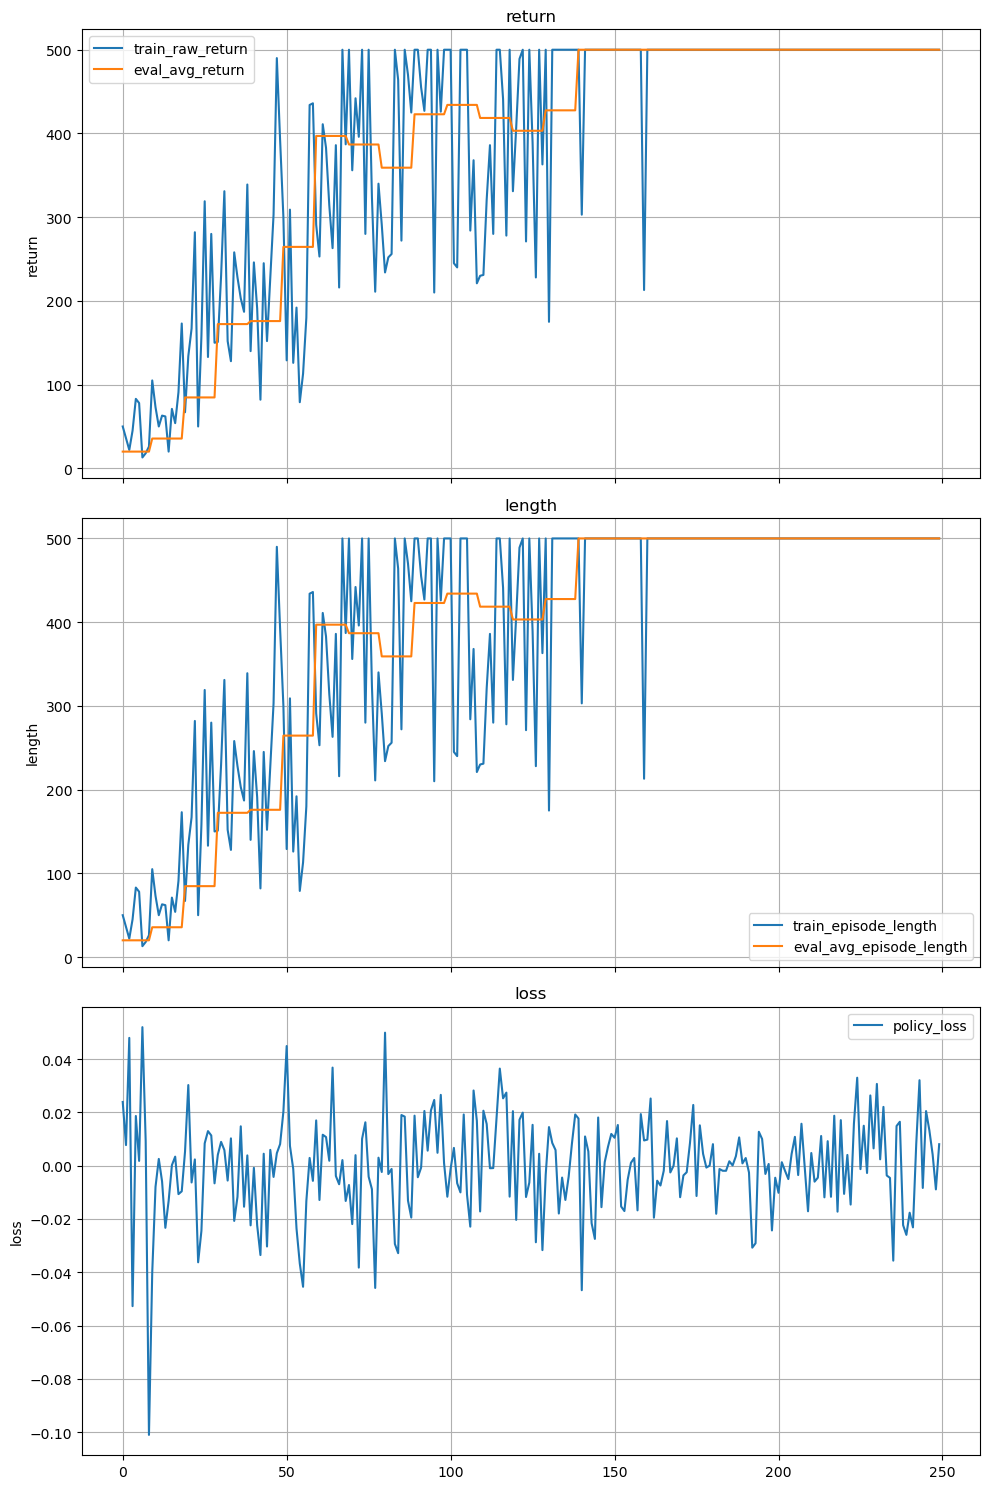

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [ ]:
# Test the policy with standardized baseline returns

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    #lr_scheduler = scheduler,
    device = device,
    run_id = "second_test",
    log_dir = log_dir
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    baseline = std_baseline,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

**The Real Exercise**: Standard practice is to use the state-value function $v(s)$ as a baseline. This is intuitively appealing -- we are more interested in updating out policy for returns that estimate the current **value** worse. Our new update becomes:

$$ \boldsymbol{\theta}_{t+1} \triangleq \boldsymbol{\theta}_t + \alpha (G_t - \tilde{v}(S_t \mid \mathbf{w})) \frac{\nabla \pi(A_t \mid s, \boldsymbol{\theta})}{\pi(A_t \mid s, \boldsymbol{\theta})} $$

where $\tilde{v}(s \mid \mathbf{w})$ is a **deep neural network** with parameters $w$ that estimates $v_\pi(s)$. What neural network? Typically, we use the **same** network architecture as that of the Policy.

**Your Task**: Modify your implementation to fit a second, baseline network to estimate the value function and use it as **baseline**. 

## ⚙️ ValueBaseline Class for Training a Value-Based Model

### ✅ Explanation

- **`__init__` method**:  
  Initializes the baseline model with:  
  - `network`: a neural network estimating the value function (state values).  
  - `criterion`: loss function (e.g., MSE) to measure prediction error.  
  - `optimizer`: optimizer to update network parameters.  
  - `lr_scheduler` (optional): adjusts learning rate during training for better convergence.  
  - `device`: sets computation device (CPU or GPU).  
  The network and criterion are moved to the specified device for efficient computation.

- **`get_advantages` method**:  
  Computes advantages used in policy gradient methods by:  
  - Converting and moving `returns` (observed discounted rewards) to the device as a tensor.  
  - Stacking observations (`obss`) into a batch tensor on the device.  
  - Predicting value estimates with the network (`preds`).  
  - Ensuring `preds` shape matches `returns` (squeezing extra dimensions if needed).  
  - Calculating the loss between predicted values and true returns.  
  - Performing backpropagation and optimizer step to update the value network.  
  - Optionally stepping the learning rate scheduler based on loss.  
  - Returning the **advantages**, computed as `returns - preds.detach()`, which represent how much better the actual returns were compared to the predicted baseline.

---

### 🧠 Theory & Why

- **Value-based baseline:**  
  A learned value function serves as a baseline to reduce variance in policy gradient estimation. Instead of using raw returns, the baseline predicts expected returns to center the advantage signal.

- **Why detach `preds` when returning advantages:**  
  Detaching `preds` prevents gradients from flowing back through the advantage calculation during policy update, ensuring the value function and policy update steps remain separated.

- **Loss and optimization inside `get_advantages`:**  
  The value network is updated every time advantages are computed, allowing the baseline to improve continually, leading to better variance reduction in policy updates.

- **Optional learning rate scheduler:**  
  Adapts learning rate dynamically depending on the loss, which can improve training stability and convergence speed.

- **Device management:**  
  Moving data and models to the right device (CPU/GPU) ensures computations are done efficiently.


In [14]:
# ValueBaseline class for training a value-based model

class ValueBaseline:
    def __init__(self, network, criterion, optimizer, lr_scheduler = None, device = 'cpu'):
        self.network      = network
        self.criterion    = criterion
        self.optimizer    = optimizer
        self.lr_scheduler = lr_scheduler
        self.device       = torch.device(device)
        
        self.network.to(self.device)
        if hasattr(self.criterion, "to"):
            self.criterion.to(self.device)
    
    def get_advantages(self, returns, obss):
        #move returns to device and ensure it's a tensor
        if not torch.is_tensor(returns):
            returns = torch.tensor(returns, dtype = torch.float32)
        returns = returns.to(self.device)          
        
        obs_batch = torch.stack([o.to(self.device) for o in obss]) 
        
        preds = self.network(obs_batch)
        
        if preds.ndim == 2 and preds.shape[1] == 1: preds = preds.squeeze(-1)

        assert preds.shape == returns.shape, f"preds {preds.shape} vs returns {returns.shape}"
        
        loss = self.criterion(preds, returns)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.lr_scheduler:
            self.lr_scheduler.step(loss.item())
        
        return returns - preds.detach()       


## ⚙️ Defining a Neural Network Baseline for Value Function Estimation

### ✅ Explanation

- **`value = MLP(...)`**:  
  Creates a multi-layer perceptron (MLP) network to estimate state values, with:  
  - Input size matching the environment's observation space dimension (`env.observation_space.shape[0]`).  
  - Hidden layers defined by `hidden_w` (width) repeated `n_hidden_layers` times.  
  - Output layer size of 1, predicting a scalar value per state.  
  - Activation functions set to ReLU for all hidden layers.  
  - Bias usage configured as `[True, False]` (likely enabling bias in some layers and disabling in others).  
  The printed `value.blocks` shows the architecture details.

- **`value_optimizer = optim.Adam(...)`**:  
  Sets up the Adam optimizer to train the value network with learning rate `lr`.

- **`criterion = nn.MSELoss()`**:  
  Uses Mean Squared Error as the loss function to measure the difference between predicted and true returns (values).

- **Learning rate scheduler (commented out):**  
  Optionally reduces the learning rate on plateau, with parameters:  
  - `mode='min'`: looks for decreases in loss.  
  - `factor=0.35`: multiplies learning rate by 0.35 when triggered.  
  - `patience=12`: waits 12 epochs before reducing.

- **Baseline creation:**  
  Instantiates the `ValueBaseline` class with the value network, criterion, optimizer, and optionally the learning rate scheduler, moving computations to the specified device.

---

### 🧠 Theory & Why

- **Why an MLP for value function:**  
  The MLP can approximate complex mappings from high-dimensional state observations to expected returns, enabling the baseline to reduce variance effectively.

- **Why use Adam optimizer:**  
  Adam adapts learning rates per parameter, often leading to faster and more stable convergence compared to vanilla SGD.

- **Why MSE loss:**  
  Since the value baseline predicts continuous scalar values, MSE is a natural choice to quantify prediction errors.

- **Why optionally use a learning rate scheduler:**  
  The scheduler helps avoid plateaus in training by reducing learning rate when progress stalls, improving final performance.

- **Why two baseline instantiation options:**  
  Allows flexibility to experiment with or without learning rate scheduling, facilitating ablation studies or tuning.


In [15]:
# Define a network as baseline for estimating the value function
# This network will be used to predict the value of states in the environment.

value = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [1],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [True, False]
)
print(value.blocks)

value_optimizer = optim.Adam(value.parameters(), lr = lr)

criterion = nn.MSELoss()

# Uncomment the following line to enable learning rate scheduling for the value optimizer

#value_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(value_optimizer, mode = 'min', factor = 0.35, patience = 12)


# Uncomment (or leave uncommented) the following line to create a ValueBaseline instance without learning rate scheduling
baseline = ValueBaseline(value, criterion, value_optimizer, device = device)

# Uncomment the following line to create a ValueBaseline instance with learning rate scheduling
#baseline = ValueBaseline(value, criterion, value_optimizer, lr_scheduler = value_lr_scheduler, device = device)

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=False)
  )
)


## ⚙️ Redefining the Policy Network as an MLP

### ✅ Explanation

- **`policy = MLP(...)`**:  
  Defines a Multi-Layer Perceptron to represent the policy network:  
  - Input layer size matches the environment's observation space dimension (`env.observation_space.shape[0]`).  
  - Hidden layers configured with `hidden_w` neurons repeated `n_hidden_layers` times.  
  - Output layer size equals the number of discrete actions available (`env.action_space.n`).  
  - Activation functions are ReLU for all hidden layers.  
  - Bias terms are disabled in all layers (`use_bias = [False, False]`), possibly to simplify the model or encourage certain regularization effects.

- **`optimizer = optim.Adam(...)`**:  
  Sets the Adam optimizer to update the policy network parameters, using the specified learning rate `lr`.

- **Learning rate scheduler (commented out):**  
  Optionally applies `ReduceLROnPlateau` to adjust learning rate based on the policy's performance metric (mode='max' since higher reward is better).  
  Parameters include:  
  - `factor = lr_s_factor`: factor by which to reduce the LR.  
  - `patience = patience * eene`: patience in terms of evaluation intervals, adapting scheduler frequency to evaluation schedule.

---

### 🧠 Theory & Why

- **Why an MLP for policy network:**  
  MLPs can approximate complex, non-linear mappings from states to action probabilities, suitable for discrete action spaces.

- **Output layer size:**  
  Matches the number of discrete actions so that the network outputs a score or logits for each possible action.

- **ReLU activations:**  
  Provide non-linearity enabling the network to model complex decision boundaries.

- **Disabling bias:**  
  Removing bias terms can reduce the number of parameters and sometimes improve generalization or simplify the model, depending on the problem.

- **Adam optimizer:**  
  Provides adaptive learning rates per parameter for efficient and stable training.

- **ReduceLROnPlateau scheduler (optional):**  
  Dynamically lowers learning rate when the policy's performance plateaus, helping escape local maxima and refine training.


In [16]:
#Redefine the policy network using a MLP (Multi-Layer Perceptron)
# This network will be used to select actions based on the observations from the environment.

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [False, False]
)

optimizer = optim.Adam(policy.parameters(), lr = lr)

# Uncomment the following line to enable learning rate scheduling for the policy optimizer

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

100%|██████████| 250/250 [01:10<00:00,  3.55it/s]

training time: 70.36s


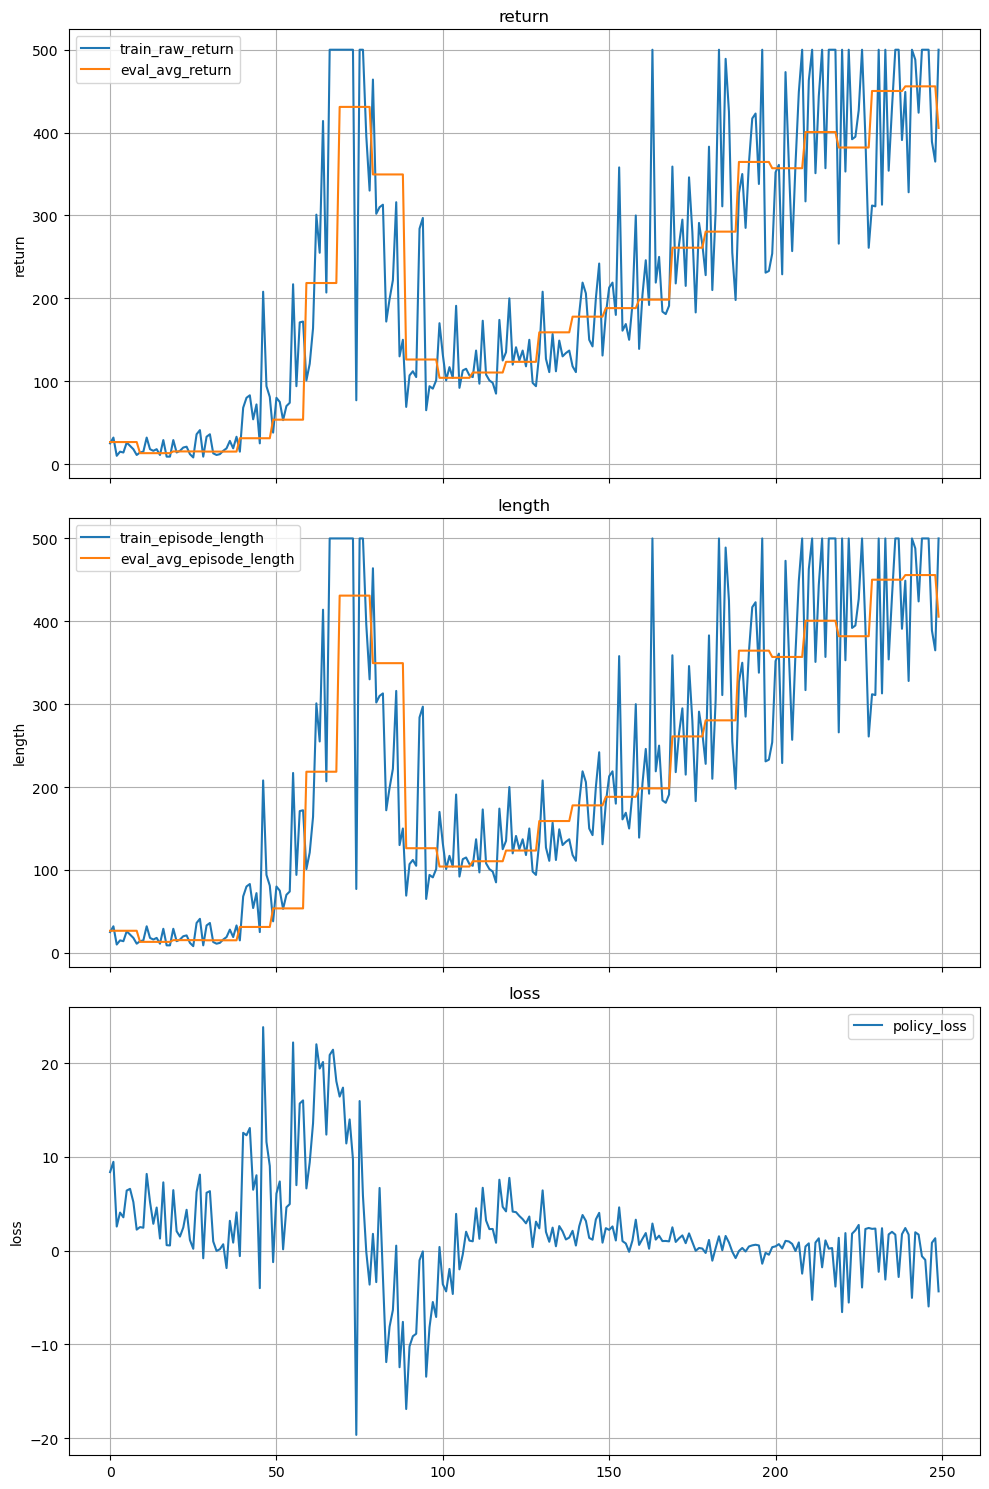

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [17]:
# Test the policy network with a dummy input to ensure it works correctly

env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    # Uncomment the following line to enable learning rate scheduling for the policy optimizer
    #lr_scheduler = scheduler,
    device = device,
    run_id = "third_test",
    log_dir = log_dir,
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    baseline = baseline.get_advantages,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.


## ⚙️ Environment Setup: LunarLander-v3 Experiment

### ✅ Explanation

- **Physics and environment parameters:**  
  - `g = 9.81`: Sets gravity to Earth's standard 9.81 m/s² (used negatively here to indicate downward acceleration).  
  - `enable_wind = True`: Enables wind effects in the environment to increase realism and difficulty.  
  - `wind_power = 7.5`: Sets the strength of the wind force applied to the lander.  
  - `turbulance_power = 1.5`: Controls the intensity of random turbulence, adding stochastic perturbations.

- **`env = gym.make(...)`**:  
  Creates the LunarLander-v3 environment with specified parameters:  
  - `continuous=False`: Discrete action space for controlling the lander.  
  - `gravity=-g`: Applies downward gravity force.  
  - `enable_wind`, `wind_power`, and `turbulence_power`: configure environmental dynamics as above.

- **`env.reset()`**:  
  Resets the environment to start a new episode.

- **Print statements:**  
  - `type(env)`: Confirms the environment object type.  
  - `type(env.observation_space)`: Confirms the observation space type (likely a Box space).  
  - `env.observation_space.shape`: Prints the shape of the state vector.  
  - `env.observation_space.low` and `.high`: Show the minimum and maximum values for each element in the observation space, defining its bounds.

- **Observation space details:**  
  The state vector consists of 8 values:  
  `[x, y, vx, vy, angle, angular_vel, left_leg_touching_ground, right_leg_touching_ground]`  
  describing the lander’s position, velocity, orientation, angular velocity, and leg contact status.




In [18]:
# Env experiment with LunarLander-v3
# This environment simulates a lunar lander that must be controlled to land safely on the moon

g = 9.81 #gravity in m/s^2
enable_wind = True 
wind_power = 7.5 #how is it?
turbulance_power = 1.5
env = gym.make("LunarLander-v3", 
                continuous = False, 
                gravity = - g, 
                enable_wind = enable_wind, 
                wind_power = wind_power, 
                turbulence_power = turbulance_power)

env.reset()
print(type(env))
print(type(env.observation_space))
# [x, y, vx, vy, angle, angular_vel, left_leg_touching_ground, right_leg_touching_ground]
print(env.observation_space.shape)
print(env.observation_space.low) 
print(env.observation_space.high)

<class 'gymnasium.wrappers.common.TimeLimit'>
<class 'gymnasium.spaces.box.Box'>
(8,)
[ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ]
[ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ]


<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## ⚙️ Adjusting Hyperparameters for the LunarLander Environment

### ✅ Explanation

- **`n_episodes = 2500`**:  
  Sets the total number of training episodes to 2500.  
  A higher episode count is chosen due to the increased complexity of LunarLander compared to simpler environments like CartPole, allowing more learning iterations.

- **`maxlen = 1000`**:  
  Defines the maximum length (timesteps) per episode.  
  LunarLander episodes can be longer than CartPole, so this allows the agent sufficient time to complete the task before termination.

- **`lr = 0.001`**:  
  Learning rate for optimizers (policy and value networks).  
  A moderate learning rate that balances stable convergence and training speed.

- **`lr_s_factor = 0.75`**:  
  Factor by which to reduce the learning rate when the scheduler triggers (i.e., multiplies current lr by 0.75).

- **`eene = 20` (evaluation every n episodes):**  
  Frequency of evaluation intervals during training.  
  Evaluating every 20 episodes helps monitor learning progress without excessive computational overhead.

- **`patience = 10`**:  
  Number of evaluation intervals to wait before reducing the learning rate if no improvement is observed.

- **`n_hidden_layers = 2`**:  
  Number of hidden layers in neural networks (policy and value).  
  More layers help model the complex state-action mappings needed for LunarLander, which has a richer observation space than simpler tasks.

---

### 🧠 Why this values?

- **Longer training and episode length:**  
  LunarLander is a more challenging control problem that requires more training time and longer episodes to learn stable landing behaviors.

- **Learning rate tuning:**  
  Carefully selected learning rates and reduction factors improve convergence and prevent oscillations during training.

- **Evaluation frequency and patience:**  
  Balances between frequent monitoring of agent performance and efficient use of computational resources.

- **Deeper networks:**  
  More hidden layers enable capturing more complex patterns in the state space, essential for effective control in environments with richer observations like LunarLander.


In [19]:
# Change some hyperparameters for the LunarLander environment
# These parameters are specific to the LunarLander environment and may differ from those used in the
# CartPole environment due to the different nature of the tasks and the complexity of the state space

n_episodes = 2500
maxlen = 1000
lr = 0.001
lr_s_factor = 0.75
eene = 20
patience = 10
n_hidden_layers = 2

In [20]:
# Define a network as baseline for estimating the value function

value = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [1],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    use_bias = [True, False]
)

value_optimizer = optim.Adam(value.parameters(), lr = lr)

criterion = nn.MSELoss()

#Uncomment the following line to enable learning rate scheduling for the value optimizer
#value_lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(value_optimizer, mode = 'min', factor = 0.35, patience = 12)

#Uncomment (or leave uncommented) the following line to create a ValueBaseline instance without learning rate scheduling
baseline = ValueBaseline(value, criterion, value_optimizer, device = device) 

#Uncomment the following line to create a ValueBaseline instance with learning rate scheduling
#baseline = ValueBaseline(value, criterion, value_optimizer, lr_scheduler = value_lr_scheduler, device = device)

In [21]:
#Redefine the policy network using a MLP (Multi-Layer Perceptron)

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    #act_funcs = [nn.ReLU] * (n_hidden_layers) + [nn.Softmax],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
    #act_funcs_params = [dict() for _ in range(n_hidden_layers)] + [dict(dim = -1)],
    use_bias = [False, False]
)

optimizer = optim.Adam(policy.parameters(), lr = lr)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

## ⚙️ Defining a Callback Function to Render the Environment During Evaluation

### ✅ Explanation

- **Import statements:**  
  Imports `time` for frame timing, `pygame` for capturing keyboard events, and constants for key detection.

- **`render(env, policy, n_try = -1)` function:**  
  - Unwraps the environment to access its raw attributes like gravity and wind parameters.  
  - Creates a new `LunarLander-v3` environment configured identically, but with `render_mode='human'` to enable on-screen rendering.  
  - Defines an inner helper `check_for_escape()` to detect if the ESC key is pressed via pygame events, allowing the user to interrupt rendering gracefully.  
  - Runs a rendering loop for `n_try` episodes (or indefinitely if `n_try = -1`):  
    - Resets environment, then repeatedly:  
      - Converts current observation to a tensor and feeds it through the policy to get action logits.  
      - Selects the action with highest logit (greedy policy).  
      - Steps the environment with the selected action and renders the frame.  
      - Sleeps to cap frame rate at ~60 FPS.  
    - Exits on episode termination or if ESC is pressed (raises `KeyboardInterrupt`).  
  - Closes rendering and returns whether the rendering was interrupted by user.

- **`render_callback(pipeline, **context)` function:**  
  - Checks if rendering should stop (`stop_rendering` flag).  
  - Only triggers rendering at evaluation intervals (`eval_every_n_episodes`) or at the final episode.  
  - Calls `render()` for a single episode (`n_try=1`).  
  - If interrupted by ESC key, sets flag to stop further rendering during training.

- **`callbacks = {"on_val_end": [render_callback]}`**:  
  Registers the `render_callback` to be called at the end of each evaluation phase during training.

---

### 🧠 Theory & Why

- **Why render during evaluation:**  
  Visual feedback helps qualitatively assess policy behavior and detect issues such as poor control or instability.

- **Using a separate environment for rendering:**  
  Avoids side effects or state pollution in the main training environment.

- **Keyboard interrupt handling:**  
  Allows the user to stop rendering gracefully without crashing the program.

- **Frame rate control:**  
  Limits rendering to ~60 FPS for smooth and consistent visuals.

- **Callback integration:**  
  Embedding rendering inside the training pipeline’s evaluation loop automates periodic visual checks without manual intervention.


In [23]:
#Define a callback function to render the environment during evaluation

import time
import pygame
from pygame.locals import K_ESCAPE

def render(env, policy, n_try = -1):
    env = env.unwrapped
    rendering = gym.make("LunarLander-v3", 
                        continuous = False, 
                        gravity = env.gravity, 
                        enable_wind = env.enable_wind, 
                        wind_power = env.wind_power, 
                        turbulence_power = env.turbulence_power,
                        render_mode = 'human')

    interrupted = False

    def check_for_escape():
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN and event.key == K_ESCAPE:
                return True
        return False

    try:
        while n_try != 0: #if n_try = -1 can be stopped only by user
            obs, info = rendering.reset()
            done = False
            while not done:
                #ESC to quit
                if check_for_escape():
                    raise KeyboardInterrupt

                obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad():
                    logits = policy(obs_tensor)
                    action = torch.argmax(logits, dim=-1).item()

                obs, reward, term, trunc, info = rendering.step(action)
                done = term or trunc
                rendering.render()
                time.sleep(1 / 60)
            n_try -= 1
    except KeyboardInterrupt:
        interrupted = True
    finally:
        rendering.close()
        return interrupted

def render_callback(pipeline, **context):
    eval_every_n_episodes = context.get("eval_every_n_episodes")
    episode = pipeline.current_episode
    n_episodes = context.get("n_episodes")
    env = context.get("env")

    if pipeline.callbacks_data.get("stop_rendering", False):
        return

    if  eval_every_n_episodes is None or \
        ((episode + 1) % eval_every_n_episodes != 0 and episode != n_episodes - 1):
        return

    interrupted = render(env = env, policy = pipeline.policy, n_try = 1)
    if interrupted:
        pipeline.callbacks_data["stop_rendering"] = True

callbacks = {"on_val_end": [render_callback]}

100%|██████████| 2500/2500 [21:09<00:00,  1.97it/s]


training time: 1269.48s


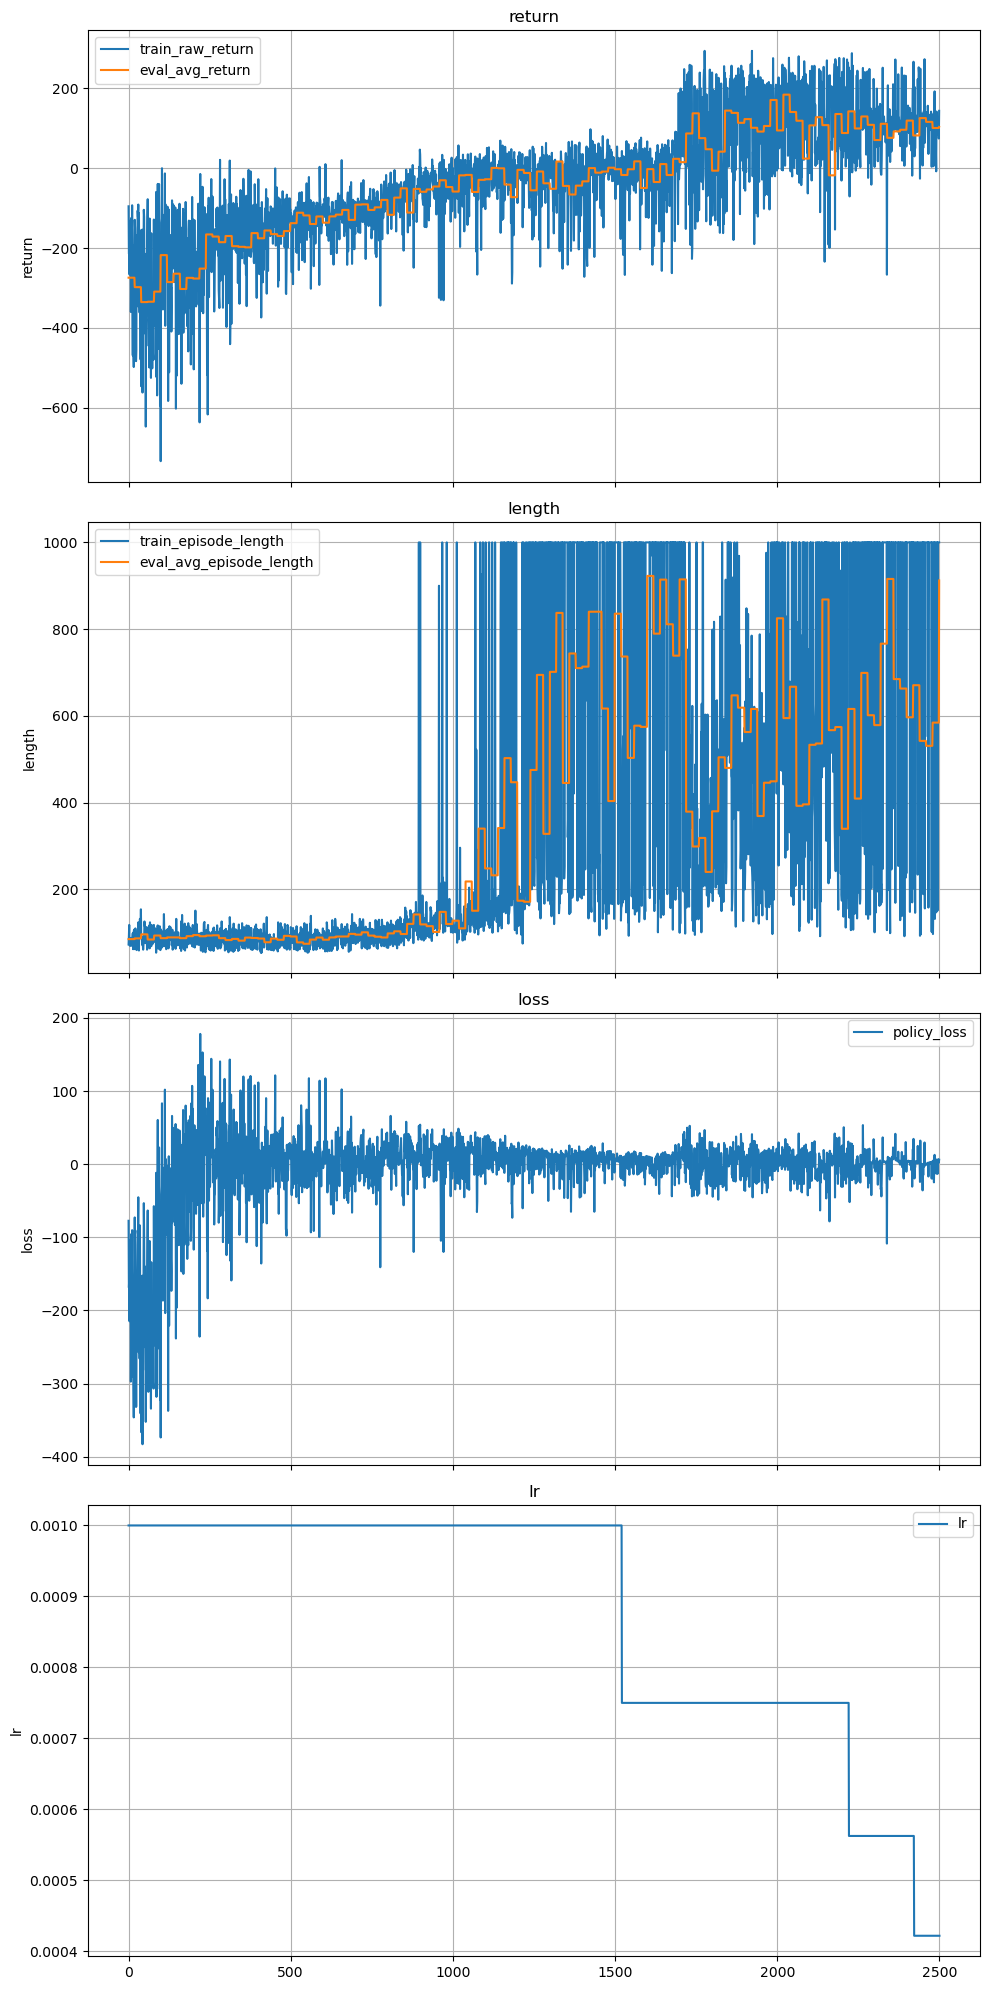

(<Figure size 1000x2000 with 4 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [24]:
#Test a policy with network as baseline
# This step ensures that the policy network can interact with the environment and produce valid actions.
env.reset()

pipeline = RLTrainingPipeline(
    policy,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    device = device,
    run_id = "lunar_landing",
    log_dir = log_dir,
    callbacks = callbacks
)

history = pipeline.reinforce(
    env = env,
    n_episodes = n_episodes,
    maxlen = maxlen,
    baseline = baseline.get_advantages,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = ee
)

pipeline.plot()

In [26]:
render(env, policy)

True


### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.



In [26]:
#REdefine the policy network using a MLP (Multi-Layer Perceptron)

lr = 1e-4 
n_hidden_layers = 3
hidden_w = 128
#patience = 13
eene = 20

policy = MLP(
    [env.observation_space.shape[0]] + [hidden_w] * n_hidden_layers + [env.action_space.n],
    act_funcs = [nn.ReLU] * (n_hidden_layers),
)

optimizer = optim.AdamW(policy.parameters(), lr = lr)

#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = lr_s_factor, patience = patience * eene)

## ⚙️ Testing a Policy with Q-Learning (DQN)

### ✅ Explanation

- **`env.reset()`**:  
  Resets the environment to start fresh before training.

- **`pipeline = QLTrainingPipeline(...)`**:  
  Initializes a Q-Learning training pipeline specialized for Deep Q-Networks (DQN):  
  - `policy`: the policy network used as the Q-function approximator.  
  - `optimizer`: optimizer for updating the policy network.  
  - `device`: computation device (CPU/GPU).  
  - `run_id`: unique identifier for this run ("cartpole_dqn").  
  - `log_dir`: directory for logging training results and metrics.  
  - `buffer_size = 10_000`: experience replay buffer size to store past transitions.

- **`pipeline.dqn(...)`**:  
  Runs the DQN training algorithm with the following settings:  
  - `env`: environment to train on.  
  - `n_episodes = 1500`: total training episodes.  
  - `maxlen = 1000`: maximum steps per episode.  
  - `batch_size = 128`: minibatch size sampled from replay buffer for updates.  
  - `gamma = 0.99`: discount factor for future rewards, encouraging long-term planning.  
  - `eps_decay = 0.995`: decay rate for epsilon in epsilon-greedy exploration, gradually reducing randomness.  
  - `verbose = False`: suppress detailed output during training.  
  - `eval_every_n_episodes = eene`: frequency of evaluation intervals.  
  - `eval_episodes = 10`: number of episodes for evaluation runs.  
  - `target_update_frequency = 7`: number of episodes between updates of the target network to stabilize training.

- **`pipeline.plot()`**:  
  Visualizes training progress, including rewards and losses.

---

### 🧠 Theory & Why

- **Q-Learning with function approximation:**  
  Uses a neural network (policy) to approximate Q-values for state-action pairs, enabling learning in high-dimensional or continuous state spaces.

- **Experience replay buffer:**  
  Stores past experiences to break correlations between sequential samples, improving training stability and sample efficiency.

- **Epsilon-greedy exploration:**  
  Starts with high exploration (random actions) and gradually shifts towards exploitation (greedy actions), balancing learning and performance.

- **Target network updates:**  
  Stabilize learning by slowly updating a separate target network, reducing oscillations and divergence.

- **Batch updates:**  
  Mini-batches sampled from the buffer improve gradient estimates and training efficiency.

- **Parameter choices:**  
  Settings like discount factor and buffer size reflect common best practices for stable DQN training on control tasks like CartPole.


100%|██████████| 1500/1500 [09:52<00:00,  2.53it/s]


training time: 592.17s


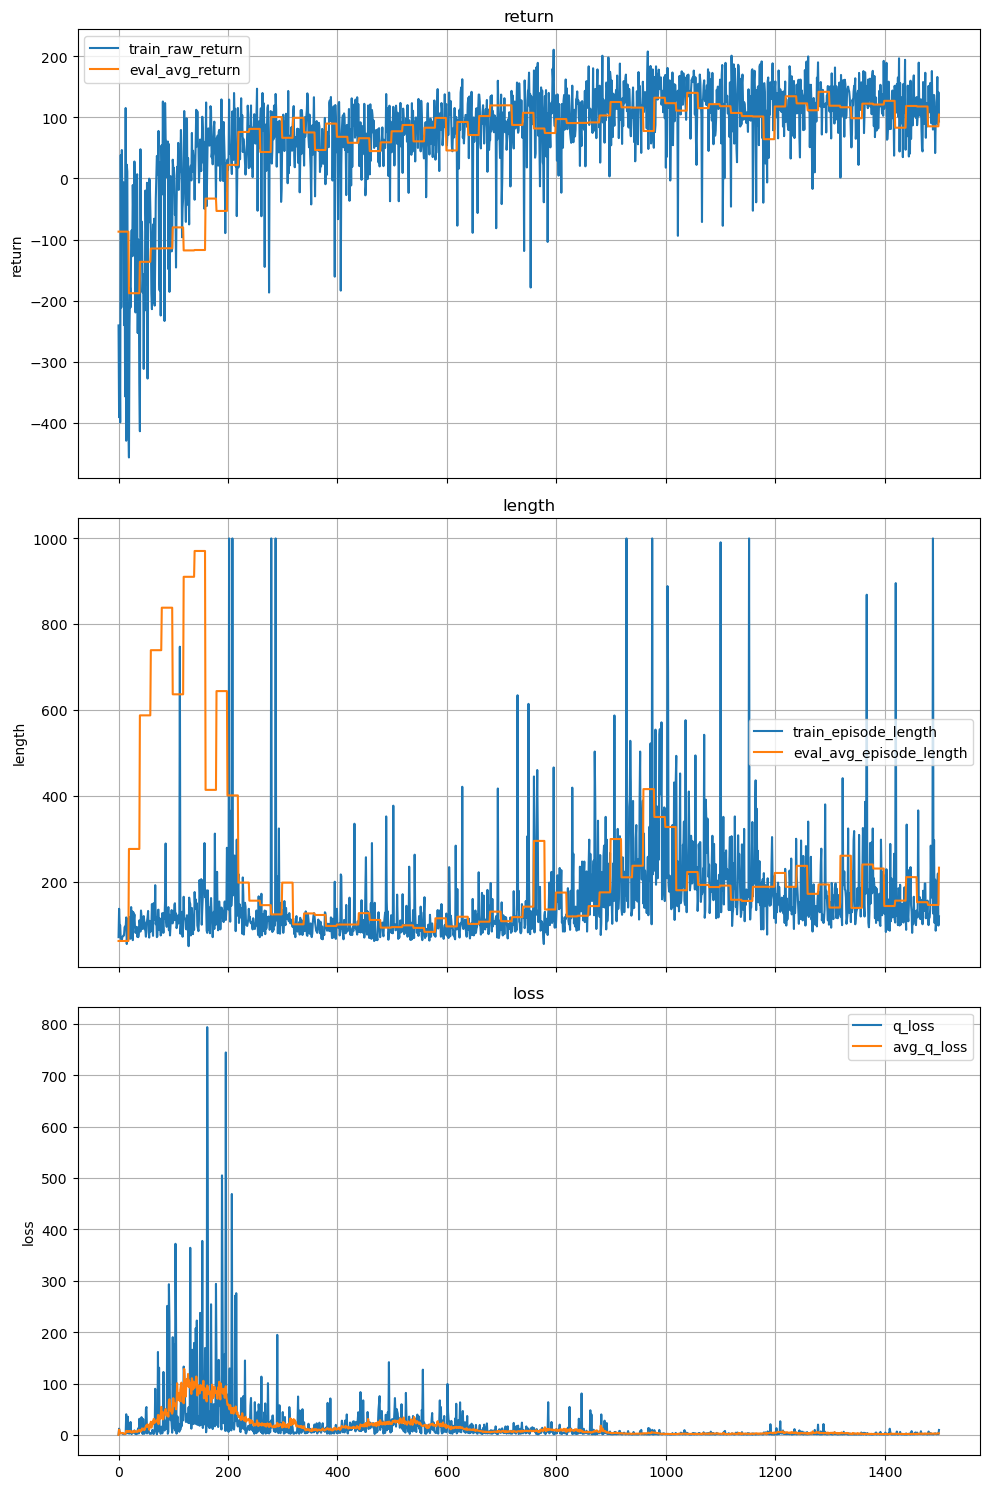

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'return'}, ylabel='return'>,
        <Axes: title={'center': 'length'}, ylabel='length'>,
        <Axes: title={'center': 'loss'}, ylabel='loss'>], dtype=object))

In [27]:
# Test a policy with q-learning

env.reset()

pipeline = QLTrainingPipeline(
    policy,
    optimizer = optimizer,
    device = device,
    #lr_scheduler = lr_scheduler,
    run_id = "cartpole_dqn",
    log_dir = log_dir,
    buffer_size = 10_000
)

history = pipeline.dqn(
    env = env,
    n_episodes = 1500,
    maxlen = 1000,
    batch_size = 128,
    gamma = 0.99,
    eps_decay = 0.995,
    verbose = False,
    eval_every_n_episodes = eene,
    eval_episodes = 10,
    target_update_frequency = 7
)

pipeline.plot()

In [28]:
render(env, policy)

False

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 